# Unsupervised Learning | Project 1 | Cars MPG Case Study

### About Dataset

The dataset was used in the 1983 American Statistical Association Exposition. The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 2 multivalued discrete and 4 continuous variables.

### Attribute Information:

Car Name – Name of the car

Cyl – No of cylinders in the car – Multivalued discrete

Disp – Displacement – continuous

Hp – Horsepower – continuous

Wt – Weight – continuous

Acc – Accleration – continuous

Yr – Model of the car – Multivalued discrete

## Import Key Modules

In [1]:
# Import Basic Libraries
import numpy as np
import pandas as pd

# Import Datavisualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set Theme for Data Visualization
%matplotlib inline
sns.set_style('whitegrid')

# Mitigating Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Libraries for Statistical Analysis
import scipy.stats as stats

# Import Libraries for Train-Test split, Scaling and Label Encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# Import Libraries for K Means Clustering
from sklearn.cluster import KMeans

# Import Core Library and Support Libraries for Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

# Set Options for Tabular Output
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

## Load Cars - MPG Dataset

Nomenclature: mpgdf -> Cars MPG Dataset

In [2]:
mpgdf = pd.read_csv("cars-dataset.csv")
mpgdf.head(5)

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0


## Data Pre - Processing

In [3]:
# 1 Cleaning any leading/trailing whitespace in the column header
mpgdf.columns = [x.strip() for x in mpgdf.columns]
mpgdf.columns

Index(['car name', 'cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'mpg'], dtype='object')

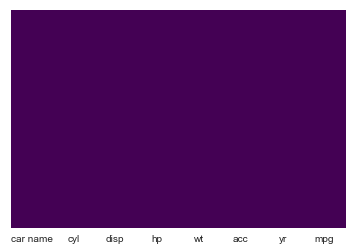

In [4]:
# 2 Missing Value through data visualization
sns.heatmap(mpgdf.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Insight: No missing values in dataset

In [5]:
# 3 Checking datatype of dataset
mpgdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 21.8+ KB


Insight: Horse Power (hp) is represented as object whereas it must be float. This leads to a question the quality of data in 'hp' column. We'll eye - ball all the columns and checkout if there is any pollution in dataset.

After eye-balling, we can see that few cells have "?" as entry. I believe these are the null/missing values which need to be treated before moving forward

In [6]:
# 3.1 Indentifying columns with polluted values (in this case '?')
mpgdf = mpgdf.replace('?',np.nan) #Converting to null value
mpgdf.isna().any()

car name    False
cyl         False
disp        False
hp          True 
wt          False
acc         False
yr          False
mpg         False
dtype: bool

Insight: We can see that horsepower in the only column with polluted values

In [7]:
# 3.2 Missing value treatment - imputing with mean
mpgdf['hp'] = mpgdf['hp'].astype(float, errors = 'ignore') #Converting into float
mpgdf['hp'] = mpgdf['hp'].fillna(mpgdf['hp'].mean()).astype(float)

In [8]:
# 3.3 Rechecking
mpgdf.isna().any()

car name    False
cyl         False
disp        False
hp          False
wt          False
acc         False
yr          False
mpg         False
dtype: bool

## Exploratory Data Analysis

In [9]:
# Describe the data
round(mpgdf.describe(),3).transpose()

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.455,1.701,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.426,104.270,68.0,104.250,148.5,262.000,455.0
hp,398.0,104.469,38.199,46.0,76.000,95.0,125.000,230.0
wt,398.0,2970.425,846.842,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568,2.758,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010,3.698,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.515,7.816,9.0,17.500,23.0,29.000,46.6


Insight: A point to be noted that all attribute have values in different scale. We need to scale the data before clustering

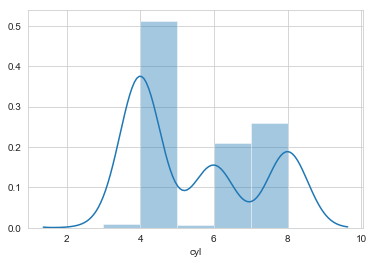

In [10]:
# Distribution plot of attributes: 1. Cyl
sns.distplot(mpgdf['cyl'])

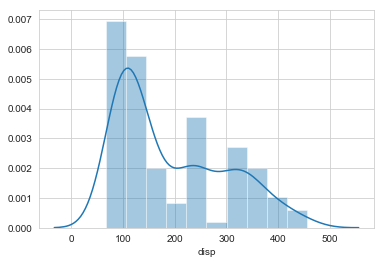

In [11]:
# Distribution plot of attributes: 2. disp
sns.distplot(mpgdf['disp'])

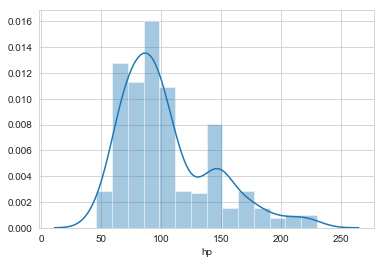

In [12]:
# Distribution plot of attributes: 3. hp
sns.distplot(mpgdf['hp'])

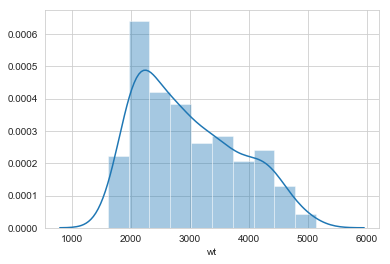

In [13]:
# Distribution plot of attributes: 4. wt
sns.distplot(mpgdf['wt'])

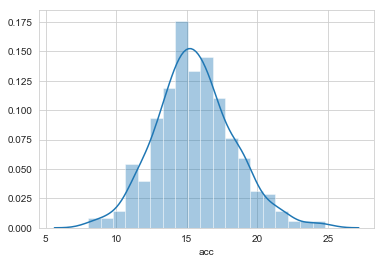

In [14]:
# Distribution plot of attributes: 4. acc
sns.distplot(mpgdf['acc'])

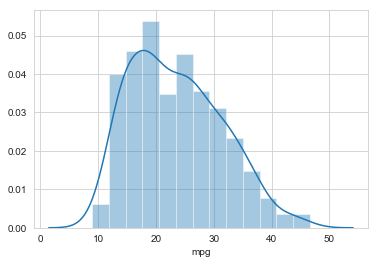

In [15]:
# Distribution plot of attributes: 5. mpg
sns.distplot(mpgdf['mpg'])

Insight: In case of 'cylinder', 'displacement', 'horse power' ans 'miles per gallon', We can see 3 gaussians in distribution plot which somehow point towards a case of gaussian mix i.e. it suggest that 3 or more clusters are available in the dataset

## Feature Engineering

Year would be more effective if we can transorm this to calculate age of vehicle. This dataset was used in 1983 so we would subtract year from 83 to get the age.

In [16]:
# In the description of the dataset we can see that this data was used in 1983.
# So, we can calculate the age of vehicle with the help of model year

# Creating Age column
mpgdf['age'] = 83-mpgdf['yr']

mpgdf.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg,age
0,chevrolet chevelle malibu,8,307.0,130.0,3504,12.0,70,18.0,13
1,buick skylark 320,8,350.0,165.0,3693,11.5,70,15.0,13
2,plymouth satellite,8,318.0,150.0,3436,11.0,70,18.0,13
3,amc rebel sst,8,304.0,150.0,3433,12.0,70,16.0,13
4,ford torino,8,302.0,140.0,3449,10.5,70,17.0,13


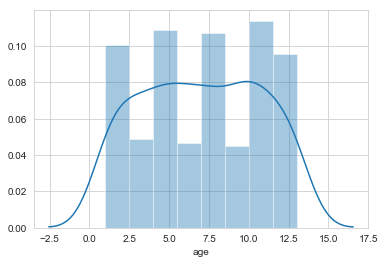

In [17]:
# Distribution plot of attributes: 6. age
sns.distplot(mpgdf['age'])

## Bi-variate analysis

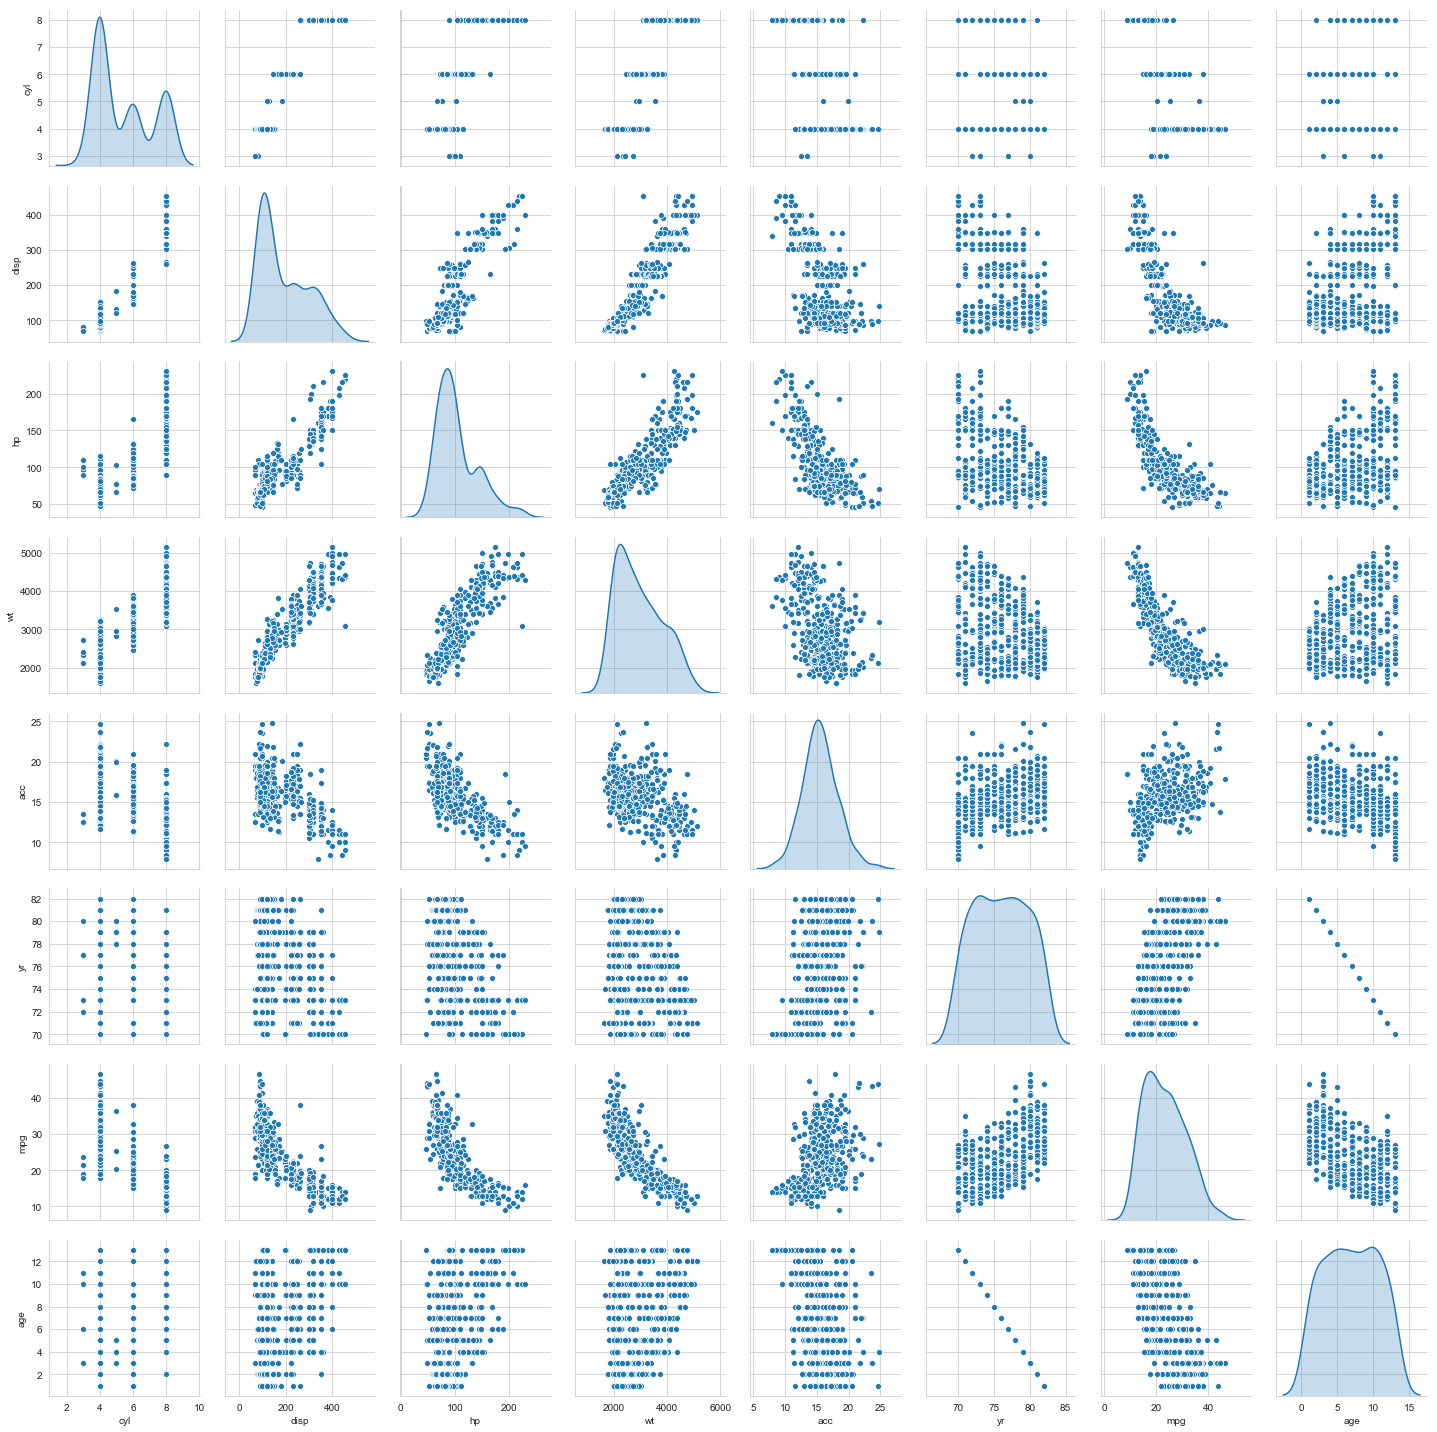

In [18]:
# 1 Pairplot
sns.pairplot(mpgdf,diag_kind = "kde")

Insights: Through pairplot we can see multi-modal gaussian in cylinder, displacement, horse power, weight, mpg and age -  suggesting that there could be possibility of gaussian mix due to different set of clusters in the dataset

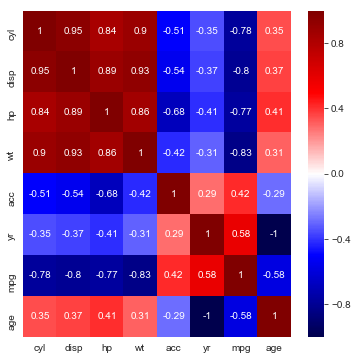

In [19]:
# 2 Correlation

fig, ax = plt.subplots()
fig.set_size_inches(6,6)
sns.heatmap(mpgdf.corr(),annot=True,vmin=-1,vmax=1,cmap='seismic')

Insights: The attributes looks likely to be highly correlated. miles per gallon is negatively correlated with cylinder, displacement, horsepower, weight and age - but, positively correlated with acceleration. Also, cylinder, displacement, horsepower and weight form a strong positive correlation, whereas all have moderate negative correlation with acceleration

## Creating Clustering Dataframe with standardize variables and imputation for any outliers

In [20]:
mpgdf.columns

Index(['car name', 'cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'mpg', 'age'], dtype='object')

In [21]:
# New Dataframe
mpgsd = mpgdf[['cyl', 'disp', 'hp', 'wt', 'acc','age','mpg']]
mpgsd.head()

,cyl,disp,hp,wt,acc,age,mpg
0,8,307.0,130.0,3504,12.0,13,18.0
1,8,350.0,165.0,3693,11.5,13,15.0
2,8,318.0,150.0,3436,11.0,13,18.0
3,8,304.0,150.0,3433,12.0,13,16.0
4,8,302.0,140.0,3449,10.5,13,17.0


In [22]:
# Standardizing the variable
mpg_sd = mpgsd.apply(stats.zscore)
mpg_sd.head()

,cyl,disp,hp,wt,acc,age,mpg
0,1.498191,1.090604,0.669196,0.630870,-1.295498,1.627426,-0.706439
1,1.498191,1.503514,1.586599,0.854333,-1.477038,1.627426,-1.090751
2,1.498191,1.196232,1.193426,0.550470,-1.658577,1.627426,-0.706439
3,1.498191,1.061796,1.193426,0.546923,-1.295498,1.627426,-0.962647
4,1.498191,1.042591,0.931311,0.565841,-1.840117,1.627426,-0.834543


## Outlier Analysis and Treatment

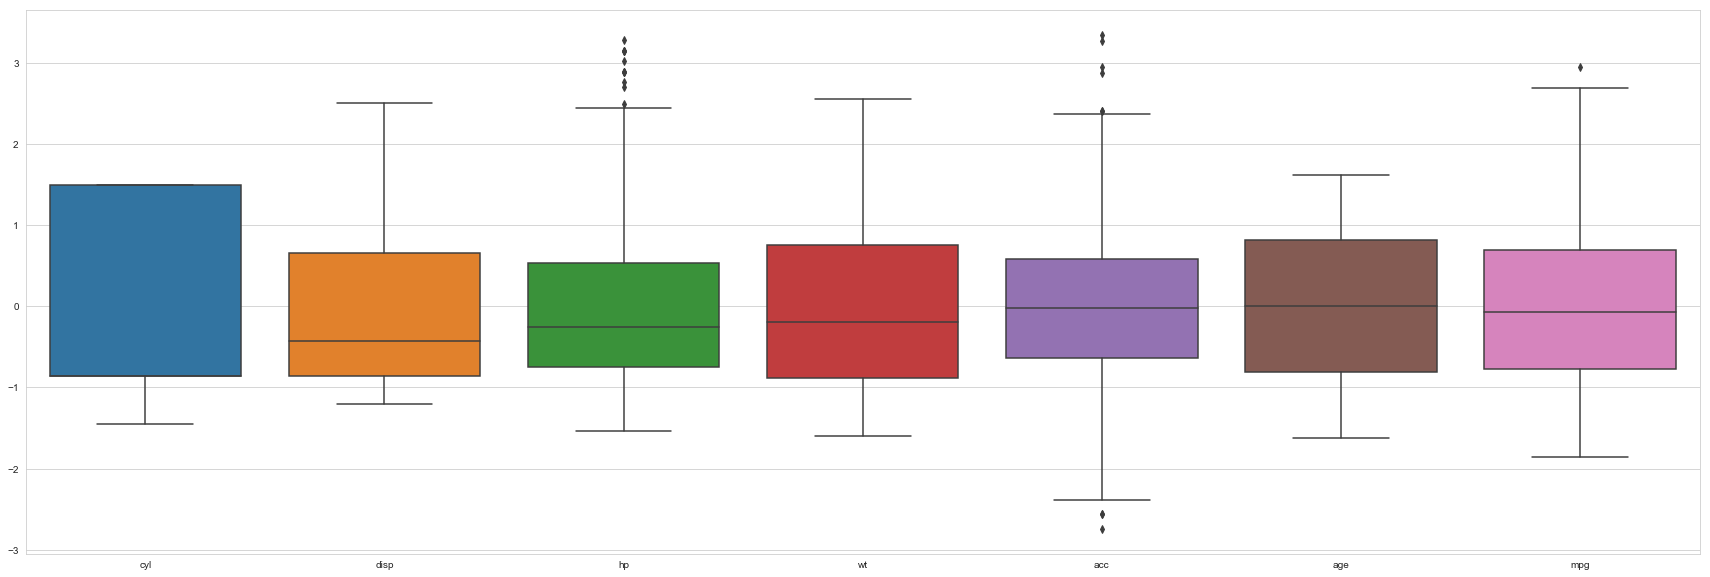

In [23]:
# BOXPLOT to see if there are any outliers in the attributes given in dataset
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
sns.boxplot(data = mpg_sd)

We can see through boxplot that few outliers are present in the dataset esp in mpg, hp and acc. So, imputing these with the mean

In [24]:
# 1 Identification of outliers
# 1.1 Calculation of first quantile (Q1), Third Quantile (Q3), and Inter Quantile Range
Q1 = mpg_sd.quantile(0.25)
Q3 = mpg_sd.quantile(0.75)
IQR = Q3 - Q1
l_bound = Q1 - (1.5*IQR)
u_bound = Q3 + (1.5*IQR)
print("IQR for attributes in dataset:\n", round(IQR,2))

IQR for attributes in dataset:
 cyl     2.35
disp    1.51
hp      1.28
wt      1.64
acc     1.22
age     1.62
mpg     1.47
dtype: float64


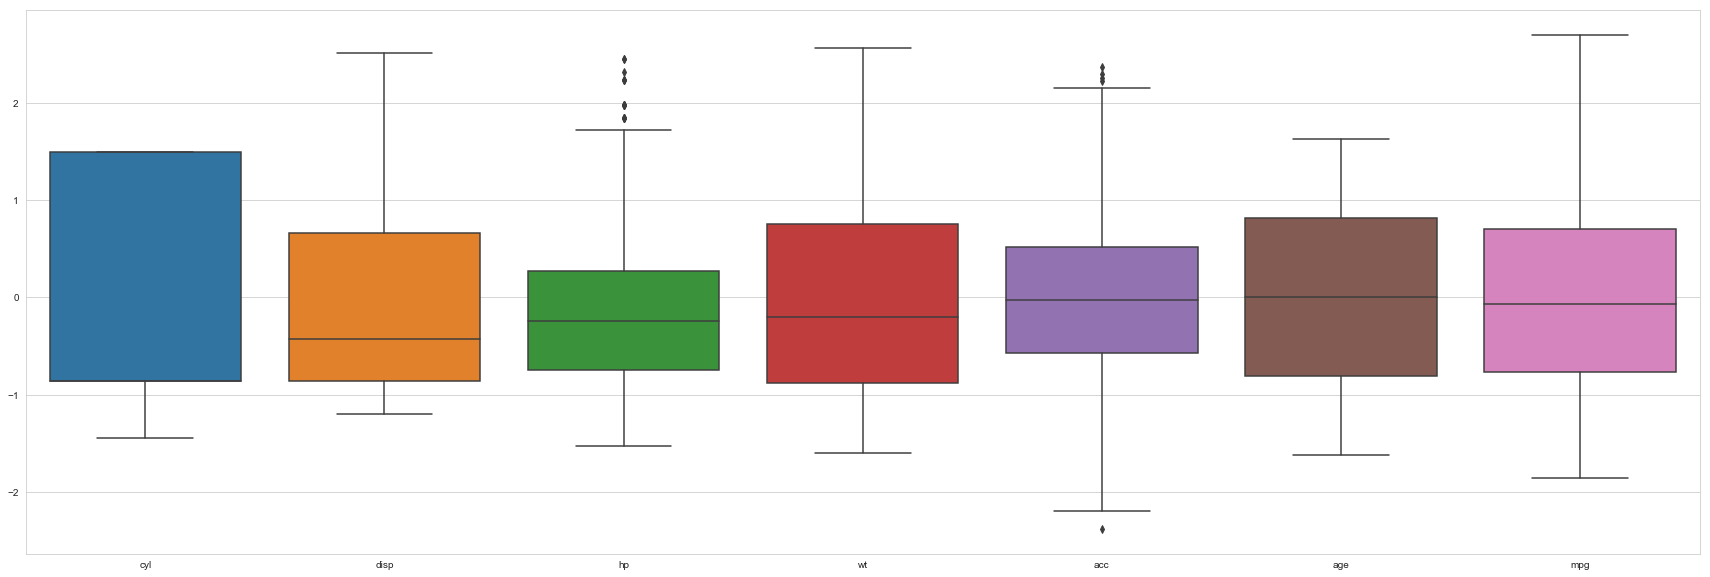

In [25]:
# 1.2 Creating a new Workbook and keeping the original dataset for reference purpose
mpgwb = mpg_sd.copy(deep = True)

# 1.3 Converting the outliers into nan and then imputing nan with mean
mpgwb[(mpgwb < l_bound) | (mpgwb > u_bound)] = np.nan
mpgwb = mpgwb.fillna(mpgwb.mean()).astype(float)

# BOXPLOT to see if there are any outliers in the attributes given in dataset
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
sns.boxplot(data = mpgwb)

## Identification of Optimum Number of Clusters using "Elbow Method"

In [26]:
# 1 Identification of Optimum Number of Clusters
cluster_range = range(2, 13)   # expect 3 to 12 clusters from the pair panel visual inspection hence restricting from 2 to 12
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans(num_clusters, n_init = 5, random_state = 1)
  clusters.fit(mpgwb)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append(clusters.inertia_)
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df['% Change_cluster errors'] = round((clusters_df['cluster_errors'].pct_change(periods= 1))*100,2)
clusters_df[0:15]

,num_clusters,cluster_errors,% Change_cluster errors
0,2,1214.165468,NaN
1,3,891.578389,-26.57
2,4,687.128356,-22.93
3,5,619.688941,-9.81
4,6,566.049730,-8.66
5,7,517.828748,-8.52
6,8,484.254405,-6.48
7,9,456.475934,-5.74
8,10,421.988325,-7.56
9,11,390.357799,-7.50


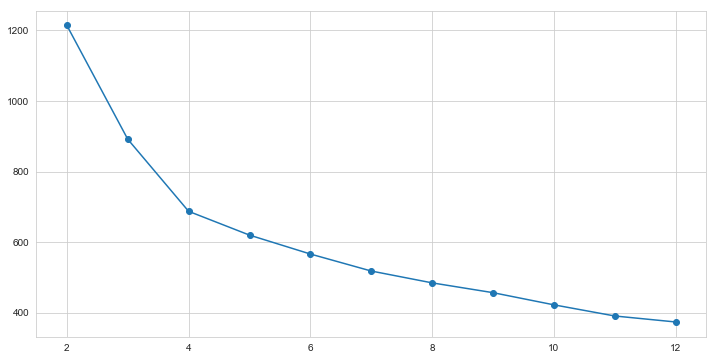

In [27]:
# 2 Elbow Plot
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

Using within cluster sum of square method, we can see drastic drop of 26.57% in cluster error from cluster = 2 to cluster = 3, which is visible through Elbow plot too. From cluster = 3 to cluster = 4 we can see that cluster error dropped again by 22.93% and further the drop is gradual, hence, we can consider k = 3 or k = 4 for further study. Lets, apply Hierarchical Clustering method to further deep dive and try to identify number of clusters.

## Using Agglomerative Hierarchical Clustering Dendogram to Identify optimum number of clusters

### #1 Identification of 'linkage' using 'cophenet index'

Cophenet Index is a measure of the correlation between the distance of points in feature space and distance on dendrogram. Closer it is to 1, the better is the clustering

In [28]:
def link(data,routines):
    Z = linkage(data,routines)
    c, coph_dists = cophenet(Z, pdist(data))
    return c
print("Cophenet Index for linkage = single\t:",round(link(mpgwb,'single'),3))
print("Cophenet Index for linkage = complete\t:",round(link(mpgwb,'complete'),3))
print("Cophenet Index for linkage = average\t:",round(link(mpgwb,'average'),3))
print("Cophenet Index for linkage = weighted\t:",round(link(mpgwb,'weighted'),3))
print("Cophenet Index for linkage = centroid\t:",round(link(mpgwb,'centroid'),3))
print("Cophenet Index for linkage = median\t:",round(link(mpgwb,'median'),3))
print("Cophenet Index for linkage = ward\t:",round(link(mpgwb,'ward'),3))

Cophenet Index for linkage = single	: 0.71
Cophenet Index for linkage = complete	: 0.759
Cophenet Index for linkage = average	: 0.794
Cophenet Index for linkage = weighted	: 0.732
Cophenet Index for linkage = centroid	: 0.792
Cophenet Index for linkage = median	: 0.701
Cophenet Index for linkage = ward	: 0.698


Insight: Here, we can see that Cophenet Index for 'average' and 'centroid' are nearer to 1. I'm moving ahead with linkage = average for Dendogram

### #2 Dendogram for chosen linkage

In [29]:
Z = linkage(mpgwb,'average')

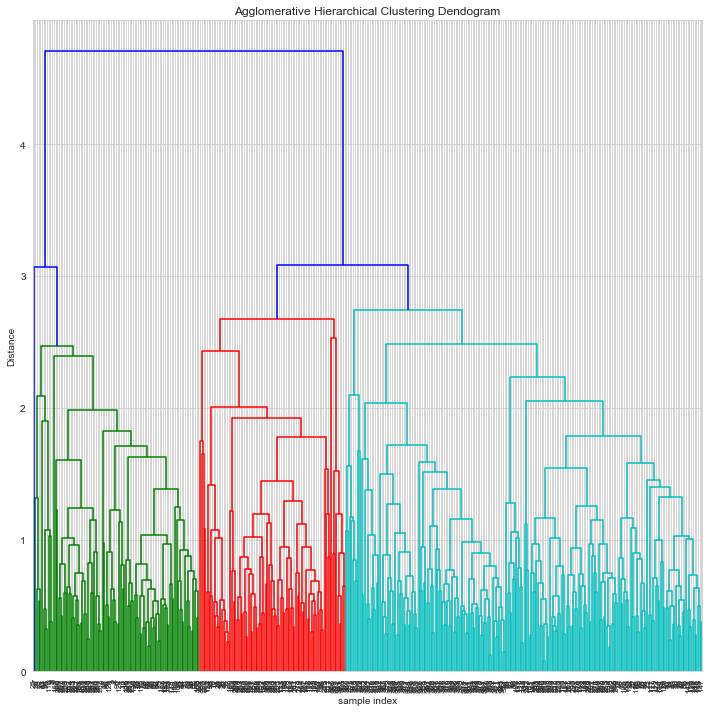

In [30]:
plt.figure(figsize=(10, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 3, leaf_font_size=8. )
plt.tight_layout()

Insight: 3 Clusters are visible through dendogram, hence considering number of clusters = 3 and applying K-Means Algorithm on dataset

## Applying K-Means Algorithm on Dataset

Number of Clusters = 3

In [31]:
# K means clustering at k = 3
cluster = KMeans(n_clusters = 3, random_state = 1)
cluster.fit(mpgwb)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [32]:
# Centroids for clusters formed
centroids = cluster.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(mpgwb) )
centroid_df

,cyl,disp,hp,wt,acc,age,mpg
0,1.498191,1.496212,1.154096,1.396142,-0.984216,0.657116,-1.155336
1,-0.842171,-0.798079,-0.662633,-0.784249,0.265929,-0.322740,0.746529
2,0.333459,0.237916,-0.067663,0.309511,0.314415,0.043051,-0.503517


In [33]:
# Assign the groups created above to data frame and study the characteristics for each group

prediction = cluster.predict(mpgwb)
mpgwb["GROUP"] = prediction     # Creating a new column "GROUP" which will hold the cluster id of each record
mpgwb.head()

,cyl,disp,hp,wt,acc,age,mpg,GROUP
0,1.498191,1.090604,0.669196,0.630870,-1.295498,1.627426,-0.706439,0
1,1.498191,1.503514,1.586599,0.854333,-1.477038,1.627426,-1.090751,0
2,1.498191,1.196232,1.193426,0.550470,-1.658577,1.627426,-0.706439,0
3,1.498191,1.061796,1.193426,0.546923,-1.295498,1.627426,-0.962647,0
4,1.498191,1.042591,0.931311,0.565841,-1.840117,1.627426,-0.834543,0


In [34]:
mpgwb.groupby(["GROUP"]).count()

,cyl,disp,hp,wt,acc,age,mpg
GROUP,,,,,,,
0,96,96,96,96,96,96,96
1,208,208,208,208,208,208,208
2,94,94,94,94,94,94,94


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14B97F30>,
      dtype=object)

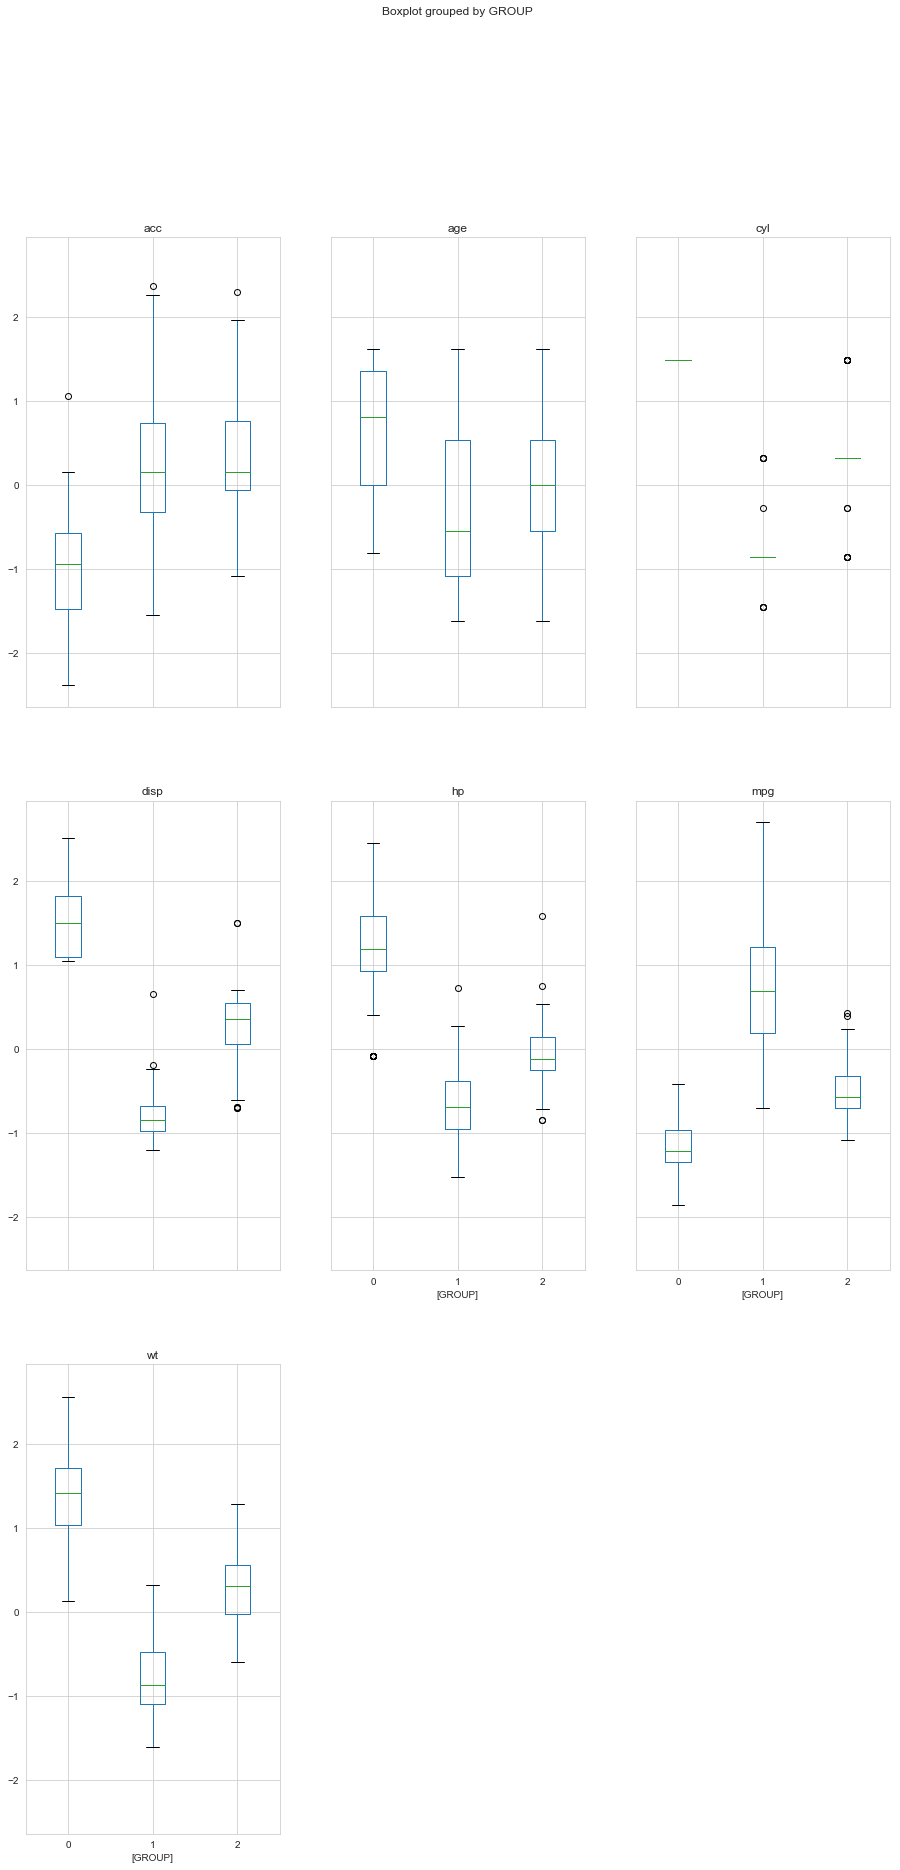

In [35]:
#Boxplot to understand the characteristics of each group
mpgwb.boxplot(by = 'GROUP',  layout=(4,3), figsize=(15, 40))

## Insights: After Analysing the Boxplots we can say that in the given set of cars data:

#### A group of cars belong to cluster with more number of cylinders, high displacement, high weight, high horse power, low acceleration and miles per galon. These looks to be Sports/luxury Cars being owned by the segment of society who doesn't focus on miles per gallon.

#### Another group of cars belong to less number of cylinders, less displacement, less horse power, less weight, mediocre acceleration and high miles per gallon. Well these cars generally owned by people who are cost cautious and focus on miles per galon. 

#### The third group is set of belonging to middle region. These are mostly compact or sub compact cars.

In [36]:
# Calling prediction in original dataset to access the characteristics
mpgdf["GROUP"] = prediction     # Creating a new column "GROUP" which will hold the cluster id of each record
mpgdf.head()
mpgdf.to_csv("mpg-cars_cluster.csv")

In [37]:
# Lets Study the first group of Cars
cars_1 = mpgdf[mpgdf["GROUP"] == 0]
round(cars_1.describe(),2)

,cyl,disp,hp,wt,acc,yr,mpg,age,GROUP
count,96.0,96.00,96.00,96.00,96.00,96.00,96.00,96.00,96.0
mean,8.0,349.24,161.77,4151.25,12.63,73.58,14.50,9.42,0.0
std,0.0,44.34,26.10,436.68,1.79,2.84,2.17,2.84,0.0
min,8.0,302.00,120.00,3086.00,8.00,70.00,9.00,4.00,0.0
25%,8.0,307.00,145.00,3847.50,11.50,71.00,13.00,7.00,0.0
50%,8.0,350.00,150.00,4177.50,12.90,73.00,14.00,10.00,0.0
75%,8.0,383.00,175.00,4428.75,13.75,76.00,16.00,12.00,0.0
max,8.0,455.00,230.00,5140.00,18.50,79.00,20.20,13.00,0.0


In [38]:
# Lets Study the second group of Cars
cars_2 = mpgdf[mpgdf["GROUP"] == 1]
round(cars_2.describe(),2)

,cyl,disp,hp,wt,acc,yr,mpg,age,GROUP
count,208.00,208.00,208.00,208.00,208.00,208.00,208.00,208.00,208.0
mean,4.02,110.31,79.19,2307.12,16.50,77.20,29.45,5.80,1.0
std,0.32,25.12,15.29,340.27,2.44,3.74,5.64,3.74,0.0
min,3.00,68.00,46.00,1613.00,11.30,70.00,18.00,1.00,1.0
25%,4.00,91.00,68.00,2049.00,14.70,74.00,25.00,3.00,1.0
50%,4.00,105.00,78.00,2239.50,16.20,78.00,29.00,5.00,1.0
75%,4.00,122.00,90.00,2566.75,18.00,80.00,33.00,9.00,1.0
max,6.00,262.00,132.00,3250.00,24.80,82.00,46.60,13.00,1.0


In [39]:
# Lets Study the second group of Cars
cars_3 = mpgdf[mpgdf["GROUP"] == 2]
round(cars_3.describe(),2)

,cyl,disp,hp,wt,acc,yr,mpg,age,GROUP
count,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.00,94.0
mean,6.02,218.20,101.89,3232.20,16.51,75.85,19.58,7.15,2.0
std,0.73,43.23,13.69,340.95,2.06,3.11,2.59,3.11,0.0
min,4.00,120.00,72.00,2472.00,12.60,70.00,15.00,1.00,2.0
25%,6.00,199.00,95.00,2949.25,15.40,74.00,18.00,5.00,2.0
50%,6.00,231.00,100.00,3239.00,16.10,76.00,19.05,7.00,2.0
75%,6.00,250.00,110.00,3443.50,17.70,78.00,21.00,9.00,2.0
max,8.00,350.00,165.00,4060.00,22.20,82.00,26.80,13.00,2.0


 ##  Linear regression model on different clusters separately and print the coefficients of the models individually

In [40]:
# Importing libraries for Linear Regression
from sklearn.linear_model import LinearRegression # Library for Linear Regression
from sklearn import metrics # For Model Evaluation

### Linear Regression on Cars with Low Miles per Gallon (cars_1)

In [41]:
cars_1.columns

Index(['car name', 'cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'mpg', 'age',
       'GROUP'],
      dtype='object')

In [42]:
# Dependent Variable and Independent Variable(s)

# Dependent Variable = mpg
Y1 = cars_1['mpg']

# Independent Variable = cyl, disp, hp, wt, acc, age | also scaling them for futher use
X1 = cars_1[['cyl', 'disp', 'hp', 'wt', 'acc','age']]

print("Shape of Dependent Variable:\n", Y1.shape,"\n")
print("Shape of Independent Variable:\n", X1.shape)

Shape of Dependent Variable:
 (96,) 

Shape of Independent Variable:
 (96, 6)


In [43]:
# Splitting dataset into training and test set in the ratio of 80:20 (Training:Test) based on dependent and independent variables

# Dividing the dataset into train and test sets
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=100)
# random state is setting up a seed value

# Shape of training and tst feature set
print("Shape of X Train:\t",X1_train.shape)
print("Shape of X Test:\t",X1_test.shape)
print("Shape of Y Train:\t",Y1_train.shape)
print("Shape of Y Test:\t",Y1_test.shape)

Shape of X Train:	 (76, 6)
Shape of X Test:	 (20, 6)
Shape of Y Train:	 (76,)
Shape of Y Test:	 (20,)


In [44]:
# Multiple Linear Regression
lm1 = LinearRegression()

# Model building on training dataset
lm1.fit(X1_train,Y1_train)

# Prediction
prediction1 = lm1.predict(X1_test)

In [45]:
# Intercept and Coefficient of Multiple Linear Regression Model
print("Intercept:",round(lm1.intercept_,3),"\n")
coefficients1 = pd.DataFrame(lm1.coef_,X1.columns)
coefficients1.columns = ['Coefficient']
print("Coefficients:")
round(coefficients1,3)

Intercept: 36.28 

Coefficients:


,Coefficient
cyl,0.000
disp,-0.007
hp,-0.025
wt,-0.001
acc,-0.608
age,-0.391


In [46]:
# Accuracy of Training and Testing data set
print("Accuracy of Training data set:\t",round(lm1.score(X1_train,Y1_train),3))
print("Accuracy of Testing data set:\t",round(lm1.score(X1_test,Y1_test),3))
print('R2 Squared:', round(metrics.r2_score(Y1_test,prediction1),3))

Accuracy of Training data set:	 0.609
Accuracy of Testing data set:	 0.204
R2 Squared: 0.204


Insight: Getting very poor R squared value for Cars with high miles per gallon

### Linear Regression on Cars with High Miles per Gallon (cars_2)

In [47]:
# Dependent Variable and Independent Variable(s)

# Dependent Variable = mpg
Y2 = cars_2['mpg']

# Independent Variable = cyl, disp, hp, wt, acc, age | also scaling them for futher use
X2 = cars_2[['cyl', 'disp', 'hp', 'wt', 'acc','age']]

print("Shape of Dependent Variable:\n", Y2.shape,"\n")
print("Shape of Independent Variable:\n", X2.shape)

Shape of Dependent Variable:
 (208,) 

Shape of Independent Variable:
 (208, 6)


In [48]:
# Splitting dataset into training and test set in the ratio of 80:20 (Training:Test) based on dependent and independent variables

# Dividing the dataset into train and test sets
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=100)
# random state is setting up a seed value

# Shape of training and tst feature set
print("Shape of X Train:\t",X2_train.shape)
print("Shape of X Test:\t",X2_test.shape)
print("Shape of Y Train:\t",Y2_train.shape)
print("Shape of Y Test:\t",Y2_test.shape)

Shape of X Train:	 (166, 6)
Shape of X Test:	 (42, 6)
Shape of Y Train:	 (166,)
Shape of Y Test:	 (42,)


In [49]:
# Multiple Linear Regression
lm2 = LinearRegression()

# Model building on training dataset
lm2.fit(X2_train,Y2_train)

# Prediction
prediction2 = lm2.predict(X2_test)

# Intercept and Coefficient of Multiple Linear Regression Model
print("Intercept:",round(lm2.intercept_,3),"\n")
coefficients2 = pd.DataFrame(lm2.coef_,X2.columns)
coefficients2.columns = ['Coefficient']
print("Coefficients:")
round(coefficients2,3)

Intercept: 35.766 

Coefficients:


,Coefficient
cyl,5.214
disp,-0.055
hp,-0.033
wt,-0.006
acc,0.101
age,-0.981


In [50]:
# Accuracy of Training and Testing data set
print("Accuracy of Training data set:\t",round(lm2.score(X2_train,Y2_train),3))
print("Accuracy of Testing data set:\t",round(lm2.score(X2_test,Y2_test),3))
print('R2 Squared:', round(metrics.r2_score(Y2_test,prediction2),3))

Accuracy of Training data set:	 0.698
Accuracy of Testing data set:	 0.587
R2 Squared: 0.587


### Linear Regression on Cars with Mediun Miles per Gallon (cars_3)

In [51]:
# Dependent Variable and Independent Variable(s)

# Dependent Variable = mpg
Y3 = cars_3['mpg']

# Independent Variable = cyl, disp, hp, wt, acc, age | also scaling them for futher use
X3 = cars_3[['cyl', 'disp', 'hp', 'wt', 'acc','age']]

print("Shape of Dependent Variable:\n", Y3.shape,"\n")
print("Shape of Independent Variable:\n", X3.shape)

Shape of Dependent Variable:
 (94,) 

Shape of Independent Variable:
 (94, 6)


In [52]:
# Splitting dataset into training and test set in the ratio of 80:20 (Training:Test) based on dependent and independent variables

# Dividing the dataset into train and test sets
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.2, random_state=100)
# random state is setting up a seed value

# Shape of training and tst feature set
print("Shape of X Train:\t",X3_train.shape)
print("Shape of X Test:\t",X3_test.shape)
print("Shape of Y Train:\t",Y3_train.shape)
print("Shape of Y Test:\t",Y3_test.shape)

Shape of X Train:	 (75, 6)
Shape of X Test:	 (19, 6)
Shape of Y Train:	 (75,)
Shape of Y Test:	 (19,)


In [53]:
# Multiple Linear Regression
lm3 = LinearRegression()

# Model building on training dataset
lm3.fit(X3_train,Y3_train)

# Prediction
prediction3 = lm3.predict(X3_test)

# Intercept and Coefficient of Multiple Linear Regression Model
print("Intercept:",round(lm3.intercept_,3),"\n")
coefficients3 = pd.DataFrame(lm3.coef_,X3.columns)
coefficients3.columns = ['Coefficient']
print("Coefficients:")
round(coefficients3,3)

Intercept: 32.955 

Coefficients:


,Coefficient
cyl,0.694
disp,-0.006
hp,-0.020
wt,-0.004
acc,0.123
age,-0.418


In [54]:
# Accuracy of Training and Testing data set
print("Accuracy of Training data set:\t",round(lm3.score(X3_train,Y3_train),3))
print("Accuracy of Testing data set:\t",round(lm3.score(X3_test,Y3_test),3))
print('R2 Squared:', round(metrics.r2_score(Y3_test,prediction3),3))

Accuracy of Training data set:	 0.428
Accuracy of Testing data set:	 0.285
R2 Squared: 0.285


## Linear Regression on Cars Dataset

In [55]:
# Dependent Variable and Independent Variable(s)

# Dependent Variable = mpg
Y = mpgdf['mpg']

# Independent Variable = cyl, disp, hp, wt, acc, age | also scaling them for futher use
X = mpgdf[['cyl', 'disp', 'hp', 'wt', 'acc','age']]

print("Shape of Dependent Variable:\n", Y.shape,"\n")
print("Shape of Independent Variable:\n", X.shape)

Shape of Dependent Variable:
 (398,) 

Shape of Independent Variable:
 (398, 6)


In [56]:
# Splitting dataset into training and test set in the ratio of 80:20 (Training:Test) based on dependent and independent variables

# Dividing the dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)
# random state is setting up a seed value

# Shape of training and tst feature set
print("Shape of X Train:\t",X_train.shape)
print("Shape of X Test:\t",X_test.shape)
print("Shape of Y Train:\t",Y_train.shape)
print("Shape of Y Test:\t",Y_test.shape)

Shape of X Train:	 (318, 6)
Shape of X Test:	 (80, 6)
Shape of Y Train:	 (318,)
Shape of Y Test:	 (80,)


In [57]:
# Multiple Linear Regression
lm = LinearRegression()

# Model building on training dataset
lm.fit(X_train,Y_train)

# Prediction
prediction = lm.predict(X_test)

# Intercept and Coefficient of Multiple Linear Regression Model
print("Intercept:",round(lm.intercept_,3),"\n")
coefficients = pd.DataFrame(lm.coef_,X.columns)
coefficients.columns = ['Coefficient']
print("Coefficients:")
round(coefficients,3)

Intercept: 47.845 

Coefficients:


,Coefficient
cyl,-0.211
disp,0.007
hp,0.004
wt,-0.007
acc,0.096
age,-0.791


In [58]:
# Accuracy of Training and Testing data set
print("Accuracy of Training data set:\t",round(lm.score(X_train,Y_train),3))
print("Accuracy of Testing data set:\t",round(lm.score(X_test,Y_test),3))
print('R2 Squared:', round(metrics.r2_score(Y_test,prediction),3))

Accuracy of Training data set:	 0.806
Accuracy of Testing data set:	 0.817
R2 Squared: 0.817


Insights: Considering overall data for development of linear regression model we're getting a better R Squared value rather than dividing the dataset into clusters and performing the task of linear regression